In [1]:
import pandas as pd
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
import os
import tensorflow as tf
import h5py
import math
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


Using TensorFlow backend.


In [ ]:
# Used while GOOGLE COLAB
"""

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/kaggle/Devnagri')

"""

In [2]:
# Reading the data in dataframe
df = pd.read_csv("data/data.csv")
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [3]:
# Analysing labels

print(df['character'].unique())
print("\nTotal unique labels : ", df['character'].nunique())
print("Total unique character : 36")
print("Total unique digits : 10")

['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha' 'character_10_yna'
 'character_11_taamatar' 'character_12_thaa' 'character_13_daa'
 'character_14_dhaa' 'character_15_adna' 'character_16_tabala'
 'character_17_tha' 'character_18_da' 'character_19_dha' 'character_20_na'
 'character_21_pa' 'character_22_pha' 'character_23_ba' 'character_24_bha'
 'character_25_ma' 'character_26_yaw' 'character_27_ra' 'character_28_la'
 'character_29_waw' 'character_30_motosaw' 'character_31_petchiryakha'
 'character_32_patalosaw' 'character_33_ha' 'character_34_chhya'
 'character_35_tra' 'character_36_gya' 'digit_0' 'digit_1' 'digit_2'
 'digit_3' 'digit_4' 'digit_5' 'digit_6' 'digit_7' 'digit_8' 'digit_9']

Total unique labels :  46
Total unique character : 36
Total unique digits : 10


In [4]:
x = df.values[:,:-1]
y = df['character'].values
num_classes = df['character'].nunique()
# Free memory
del df


In [5]:
# Splitting the data in train, validation and test set

# Training set = 70% of original data
# Validation set = 15% of original data
# Test set = 15% of original data

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(x, y, test_size=0.30, random_state=42)
X_val_orig, X_test_orig, Y_val_orig, Y_test_orig = train_test_split(X_test_orig, Y_test_orig, test_size=0.50, random_state=42)

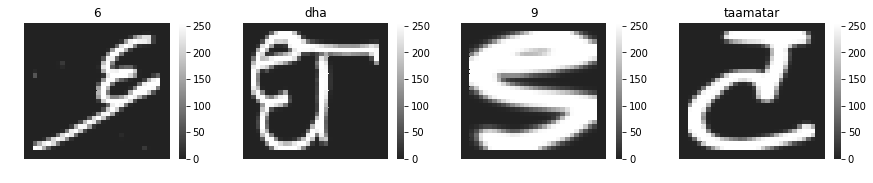

In [7]:
# Some sample data

img_width_cols = 32
img_height_rows = 32
cutsomcmap = sns.dark_palette("white", as_cmap=True)
random_idxs = random.sample(range(1, len(Y_train_orig)), 4)
plt_dims = (15, 2.5)
f, axarr = plt.subplots(1, 4, figsize=plt_dims)
it = 0
for idx in random_idxs:
    image = X_train_orig[idx, :].reshape((img_width_cols, img_height_rows))
    axarr[it].set_title(Y_train_orig[idx].split("_")[-1])
    axarr[it].axis('off')
    sns.heatmap(data=image.astype(np.uint8), cmap=cutsomcmap, ax=axarr[it])
    it = it+1

In [8]:
# Encoding the target variable into integer labels

le = LabelEncoder()
Y_train_orig1 = le.fit_transform(Y_train_orig)
Y_test_orig1 = le.transform(Y_test_orig)
Y_val_orig1 = le.transform(Y_val_orig)
#print(Y_train, Y_test)
di = dict(zip(le.classes_, le.transform(le.classes_)))
print(di)

{'character_01_ka': 0, 'character_02_kha': 1, 'character_03_ga': 2, 'character_04_gha': 3, 'character_05_kna': 4, 'character_06_cha': 5, 'character_07_chha': 6, 'character_08_ja': 7, 'character_09_jha': 8, 'character_10_yna': 9, 'character_11_taamatar': 10, 'character_12_thaa': 11, 'character_13_daa': 12, 'character_14_dhaa': 13, 'character_15_adna': 14, 'character_16_tabala': 15, 'character_17_tha': 16, 'character_18_da': 17, 'character_19_dha': 18, 'character_20_na': 19, 'character_21_pa': 20, 'character_22_pha': 21, 'character_23_ba': 22, 'character_24_bha': 23, 'character_25_ma': 24, 'character_26_yaw': 25, 'character_27_ra': 26, 'character_28_la': 27, 'character_29_waw': 28, 'character_30_motosaw': 29, 'character_31_petchiryakha': 30, 'character_32_patalosaw': 31, 'character_33_ha': 32, 'character_34_chhya': 33, 'character_35_tra': 34, 'character_36_gya': 35, 'digit_0': 36, 'digit_1': 37, 'digit_2': 38, 'digit_3': 39, 'digit_4': 40, 'digit_5': 41, 'digit_6': 42, 'digit_7': 43, 'di

In [9]:
# Shape of train and test data

Y_train_orig1=Y_train_orig1.reshape(-1,1)
Y_val_orig1=Y_val_orig1.reshape(-1,1)
Y_test_orig1=Y_test_orig1.reshape(-1,1)
X_train_orig=X_train_orig.reshape(-1,32,32,1)
X_val_orig=X_val_orig.reshape(-1,32,32,1)
X_test_orig=X_test_orig.reshape(-1,32,32,1)

In [10]:
print(X_train_orig.shape, Y_train_orig1.shape, X_val_orig.shape, Y_val_orig1.shape, X_test_orig.shape, Y_test_orig1.shape)


(64400, 32, 32, 1) (64400, 1) (13800, 32, 32, 1) (13800, 1) (13800, 32, 32, 1) (13800, 1)


In [11]:

# Normalize image vectors
X_train = X_train_orig.astype('float32')/255.
X_val = X_val_orig.astype('float32')/255.
X_test = X_test_orig.astype('float32')/255.
x_train_mean = np.mean(X_train, axis=0)
X_train -= x_train_mean
X_val -= x_train_mean
X_test -= x_train_mean

# Convert training, validation and test labels to one hot matrices
Y_train = to_categorical(Y_train_orig1, num_classes)
Y_val = to_categorical(Y_val_orig1,num_classes )
Y_test = to_categorical(Y_test_orig1,num_classes )

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 64400
number of validation examples = 13800
number of test examples = 13800
X_train shape: (64400, 32, 32, 1)
Y_train shape: (64400, 46)
X_val shape: (13800, 32, 32, 1)
Y_val shape: (13800, 46)
X_test shape: (13800, 32, 32, 1)
Y_test shape: (13800, 46)


In [15]:
"""
Learning Rate Schedule
Learning rate is scheduled to be reduced after 40, 60, 80, 90 epochs.
Called automatically every epoch as part of callbacks during training.

"""
    
def lr_schedule(epoch):
   
    lr = 1e-3
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

![title](../img/Identity_block.png)

In [16]:
# Identity Block

def identity_block(X, f, filters, stage, block):
  
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value. We will need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    return X

![title](img/Convolution_block.png)

In [17]:
# Convolution Block

def convolutional_block(X, f, filters, stage, block, padding = "same", s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    pad = padding

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (s,s), padding="same", name = conv_name_base + '2a', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(F2, (3, 3), strides = (1,1), padding="same", name = conv_name_base + '2b', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    
    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), padding="same", name = conv_name_base + '1', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X_shortcut)
    X_shortcut = BatchNormalization(name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

![title](img/ResNet20_block.png)

In [18]:
def ResNet20(input_shape = (32, 32, 1), classes):
    """
    Implementation of the ResNet20 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*2-> CONVBLOCK -> IDBLOCK*2 
    -> AVGPOOL -> FLATTEN -> DENSE
      
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    X = X_input
    
    # Stage 1 ( CONV -> Batch Normalization -> Relu )
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = "same", name = 'conv1', kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    
    # Stage 2 ( LAYER 1 )
    X = convolutional_block(X, f = 3, filters = [16, 16], stage = 2, block='a', padding="same", s = 1)
    X = identity_block(X, 3, [16, 16], stage=2, block='b')
    X = identity_block(X, 3, [16, 16], stage=2, block='c')

    # Stage 3 ( LAYER 2 )
    X = convolutional_block(X, f = 3, filters = [32, 32], stage = 3, block='a', padding="same", s = 2)
    X = identity_block(X, 3, [32, 32], stage=3, block='b')
    X = identity_block(X, 3, [32, 32], stage=3, block='c')

    # Stage 4 ( LAYER 3 )
    X = convolutional_block(X, f = 3, filters = [64, 64], stage = 4, block='a', padding="same", s = 2)
    X = identity_block(X, 3, [64, 64], stage=4, block='b')
    X = identity_block(X, 3, [64, 64], stage=4, block='c') 
    
    # Stage 5

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)
    # OUTPUT LAYER ( FLATTEN + DENSE )
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer='he_normal')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet20')

    return model

In [19]:
# Creating Model by calling ResNet20()

model = ResNet20(input_shape = (32, 32, 1), classes = num_classes)

In [20]:
# Compling Model using adam optimizer and categorical_crossentropy as loss or cost function.

model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Saving models and checkpointing

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % 'ResNet20'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [22]:
# Fitting the model ( Training and validating)

history = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_val, Y_val), shuffle=True, callbacks = callbacks, verbose = 2)

Train on 64400 samples, validate on 13800 samples
Epoch 1/100
 - 37s - loss: 0.7460 - accuracy: 0.8402 - val_loss: 0.2955 - val_accuracy: 0.9595
Epoch 2/100
 - 27s - loss: 0.2532 - accuracy: 0.9709 - val_loss: 0.2619 - val_accuracy: 0.9650
Epoch 3/100
 - 27s - loss: 0.2140 - accuracy: 0.9794 - val_loss: 0.2339 - val_accuracy: 0.9740
Epoch 4/100
 - 27s - loss: 0.1966 - accuracy: 0.9823 - val_loss: 0.2101 - val_accuracy: 0.9796
Epoch 5/100
 - 27s - loss: 0.1747 - accuracy: 0.9867 - val_loss: 0.1903 - val_accuracy: 0.9821
Epoch 6/100
 - 27s - loss: 0.1650 - accuracy: 0.9877 - val_loss: 0.2018 - val_accuracy: 0.9763
Epoch 7/100
 - 27s - loss: 0.1523 - accuracy: 0.9888 - val_loss: 0.2241 - val_accuracy: 0.9694
Epoch 8/100
 - 27s - loss: 0.1432 - accuracy: 0.9896 - val_loss: 0.1689 - val_accuracy: 0.9823
Epoch 9/100
 - 27s - loss: 0.1312 - accuracy: 0.9908 - val_loss: 0.1602 - val_accuracy: 0.9833
Epoch 10/100
 - 27s - loss: 0.1278 - accuracy: 0.9904 - val_loss: 0.1797 - val_accuracy: 0.9789

In [23]:
# Keys present in history

for key in history.history.keys():
    print(key)

val_loss
val_accuracy
loss
accuracy
lr


In [24]:
# Saving history for future analysis

np.save('Dev_val_ResNet20_He_w_reg.npy',history.history)

In [25]:
# Loading the history

history=np.load('Dev_val_ResNet20_He_w_reg.npy',allow_pickle='TRUE').item()

In [26]:
history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

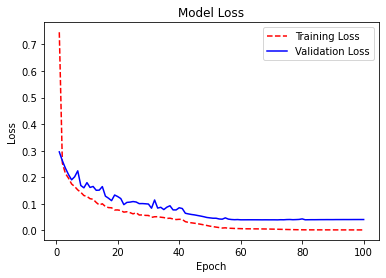

In [27]:
# Plotting training and validation loss

training_loss = history['loss']
val_loss = history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.title('Model Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

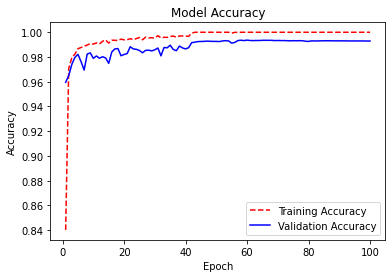

In [28]:
# Plotting training and validation accuracy

training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.title('Model Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [29]:

##### SAVING MODEL SO WE DON'T HAVE TO TRAIN IT EVERYTIME,AND PARAMETERS CAN BE RESUSED

model.save('Dev_val_ResNet20_He_w_reg.h5')

In [30]:
##### LOADING MODEL TO EVALUATE TEST DATA

model= load_model('Dev_val_ResNet20_He_w_reg.h5')

In [31]:
##### Calculating loss and accuracy on test data

preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy(out of 1) = " + str(preds[1]))
print ("Test Accuracy(in %) = " + str(preds[1]*100))

13800/13800 [==============================] - 3s 253us/step
Loss = 0.03887863038431691
Test Accuracy(out of 1) = 0.9927536249160767
Test Accuracy(in %) = 99.27536249160767


In [32]:
# Summary of model, calculating the output shape and number of parameters at different stages .

print(model.summary())

Model: "ResNet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Visulaizing the structure of our model 'ResNet20' using Flowchart

# Needs GraphViz module
#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Flowchart

![title](model.png)

In [34]:
# Predicting class of test data

y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

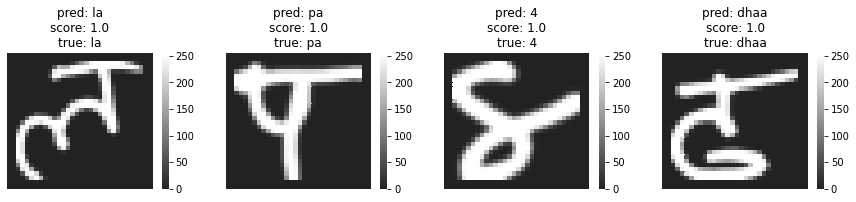

In [35]:
img_width_cols = 32
img_height_rows = 32
cutsomcmap = sns.dark_palette("white", as_cmap=True)
random_idxs = random.sample(range(1, len(Y_test)), 4)
plt_dims = (15, 2.5)
f, axarr = plt.subplots(1, 4, figsize=plt_dims)
it = 0
for idx in random_idxs:
    image = (X_test[idx, :] + x_train_mean).reshape(32,32) * 255
    axarr[it].axis('off')
    pred_label = list(di.keys())[list(di.values()).index(y_pred_test_classes[idx])].split("_")[-1]
    pred_proba = y_pred_test_max_probas[idx]
    true_label = Y_test_orig[idx].split("_")[-1]
    axarr[it].set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(pred_label, pred_proba, true_label))
    sns.heatmap(data=image.astype(np.uint8), cmap=cutsomcmap, ax=axarr[it])
    it = it+1
    

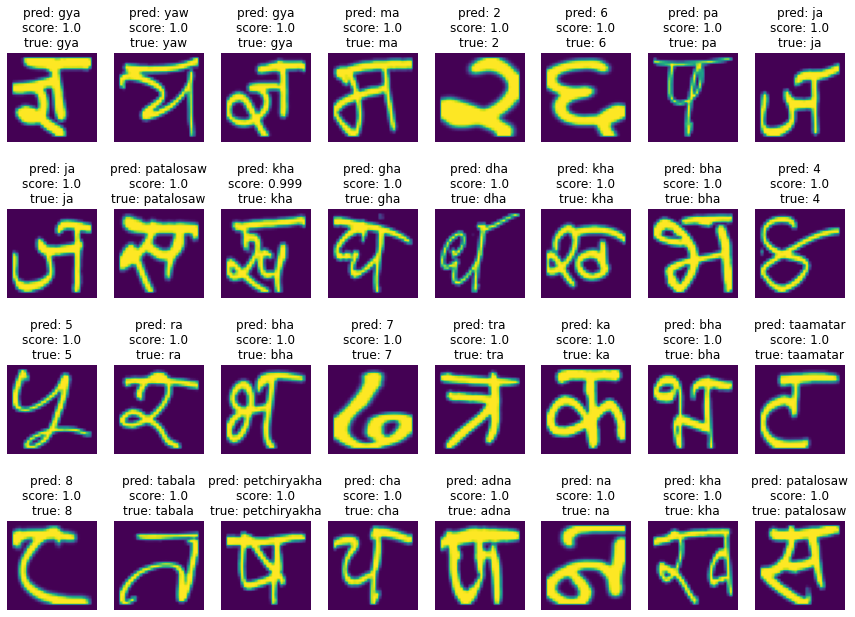

In [36]:
# Predicting and plotting random data

cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        idx = np.random.randint(0, len(Y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow((X_test[idx, :]+x_train_mean).astype("float32").squeeze())
        pred_label = list(di.keys())[list(di.values()).index(y_pred_test_classes[idx])].split("_")[-1]
        pred_proba = y_pred_test_max_probas[idx]
        true_label = Y_test_orig[idx].split("_")[-1]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(pred_label, pred_proba, true_label))
plt.show()